# IART Assignment 2 - Airlines Delay

## Group

* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* João Veloso, up202005801

## Data analysis

In [ ]:
svm_md = SVC(kernel='linear', C=1, random_state=42)
svm_md.fit(X_train, Y_train)

svm_pred = svm_md.predict(X_test)
print('Accuracy Score: ', round(accuracy_score(Y_test, svm_pred)*100, 2), '%')
print('F-1 Score: ', round(f1_score(Y_test, svm_pred)*100, 2), '%')
print('Precision Score: ', round(precision_score(Y_test, svm_pred)*100, 2), '%')
print('Recall Score: ', round(recall_score(Y_test, svm_pred)*100, 2), '%')


In [85]:
import pandas as pd
import seaborn as sb
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score, mean_squared_log_error, accuracy_score,recall_score, f1_score, precision_score, confusion_matrix 
from sklearn.svm import SVC
from sklearn import tree
import time
import matplotlib.pyplot as plt

In [36]:
data = pd.read_csv('airlines_delay.csv')

data.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [ ]:
data.describe()

In [ ]:
print("There are " + str(data.shape[0]) + " rows and " + str(data.shape[1]) + " cols in the dataset")

In [ ]:
%matplotlib inline

sb.countplot(x = 'Class', data = data)
# 0 = flight not delayed
# 1 = flight delayed

In [ ]:
data['Airline'].value_counts().plot.barh()

In [ ]:
sb.countplot(x = 'Airline', hue = 'Class', data = data)

WN has by far the most amount of delays

In [ ]:
sb.barplot(x = 'Airline', y = 'Length', data = data)
#Average flight duration

In [ ]:
sb.barplot(x = 'Airline', y = 'Time', data = data)

Flight departure are similar between all the different airlines


### Attributes
 
Attribute | Type | Properties | Discrete vs Continuous |
| - | - | - | - |
| Flight | Nominal | Distinctness | Discrete |
| Time | Interval | Distinctness, order, and meaningful differences | Continuous |
| Length | Ratio | Distinctness, order, meaningful differences, and ratios are meaningful | Continuous |
| Airline | Nominal | Distinctness | Discrete |
| AirportFrom | Nominal | Distinctness | Discrete |
| AirportTo | Nominal | Distinctness | Discrete |
| DayOfWeek | Ordinal | Distinctness and order | Discrete | 
| Class | Nominal | Distinctness | Discrete |

## Data pre-processing

### NA values

In [ ]:
print(data.isna().sum())
print()
print("There are " + str((data.isna().sum().sum())) + " NA values")

### Duplicate values

In [ ]:
length = len(data)
##data.drop_duplicates(inplace=True)

print("Original dataset length: " + str(length))
print("Number of duplicates: " + str(length - len(data)))

### Outliers

In [ ]:
%matplotlib inline

sb.pairplot(data, hue='Class')

In [ ]:
def detecting_outliers(data):
    outlier_percents = {}
    
    for column in data.columns:

        if data[column].dtype != object:
            
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper = q3 + (1.5 * iqr)
            lower = q1 - (1.5 * iqr)
            outliers = data[(data[column] > upper) | (data[column] < lower)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_df = pd.DataFrame(data = outlier_percents.values(), index = outlier_percents.keys(), columns = ['Outlier_%'])
            
    return outlier_df.sort_values(by = 'Outlier_%', ascending = False)
        
detecting_outliers(data)

#### Remove Outliers

In [ ]:
outlier_df = detecting_outliers(data)
cols_with_outliers = outlier_df[outlier_df['Outlier_%'] > 0].index
for col in cols_with_outliers:
    q1 = np.quantile(data[col], 0.25)
    q3 = np.quantile(data[col], 0.75)
    iqr = q3 - q1
    upper = q3 + (1.5 * iqr)
    lower = q1 - (1.5 * iqr)
    data = data[(data[col] <= upper) & (data[col] >= lower)]

In [ ]:
%matplotlib inline

sb.pairplot(data, hue='Class')  

### Encoding Categorical Features

In [37]:
data['AirportTo'] = LabelEncoder().fit_transform(data['AirportTo'])

In [38]:
data['AirportFrom'] = LabelEncoder().fit_transform(data['AirportFrom'])

In [39]:
data['Airline'] = LabelEncoder().fit_transform(data['Airline'])

In [ ]:
data.head()

## Making Train and Test data

In [40]:
X = data[['Time', 'Length', 'Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']]
Y = data['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Algorithms

## Decision Tree

In [90]:
# Define parameter grid
param_dt = {'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19]}

# Create Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Create grid search object
dt_grid = GridSearchCV(dt, param_dt, cv=5, scoring='accuracy')

# Fit grid search on training data
start_time = time.time()
dt_grid.fit(X_train, Y_train)
train_time = time.time() - start_time

# Get best parameters and score
best_dt = dt_grid.best_estimator_
best_dt_params = dt_grid.best_params_
best_dt_score = dt_grid.best_score_

# Evaluate best Decision Tree model on test data
start_time = time.time()
dt_train_pred = best_dt.predict(X_train)
dt_test_pred = best_dt.predict(X_test)
test_time = time.time() - start_time

print('Best Parameters:', best_dt_params)
print('Best Score:', round(best_dt_score*100, 2), '%')
print('Precision Score:', round(precision_score(Y_test, dt_test_pred)*100, 2), '%')
print('Recall Score:', round(recall_score(Y_test, dt_test_pred)*100, 2), '%')
print('Accuracy Score:', round(accuracy_score(Y_test, dt_test_pred)*100, 2), '%')
print('F-1 Score:', round(f1_score(Y_test, dt_test_pred)*100, 2), '%')
print('Training time:', round(train_time, 2), 'seconds')
print('Testing time:', round(test_time, 2), 'seconds')


Best Parameters: {'max_depth': 11}
Best Score: 64.81 %
Precision Score: 63.78 %
Recall Score: 48.21 %
Accuracy Score: 64.61 %
F-1 Score: 54.91 %
Training time: 25.83 seconds
Testing time: 0.04 seconds


### Confusion Matrix - Training 

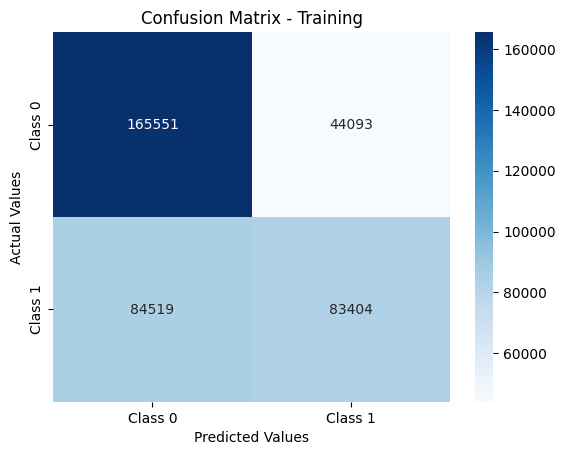

In [91]:
cm_train = confusion_matrix(Y_train, dt_train_pred)
class_labels = ['Class 0', 'Class 1']
sb.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### Confusion Matrix - Test
 

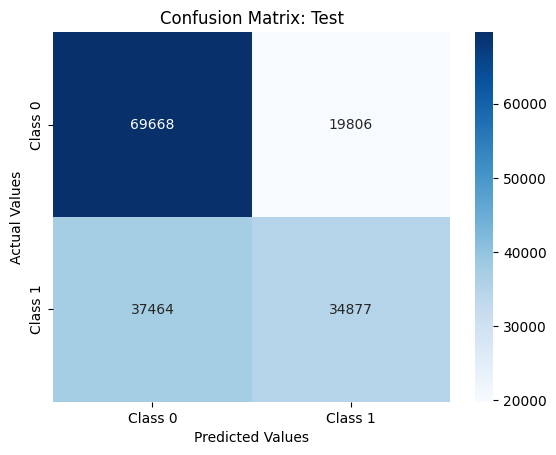

In [92]:
cm = confusion_matrix(Y_test, dt_test_pred)

class_labels = ['Class 0', 'Class 1']

sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix: Test')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

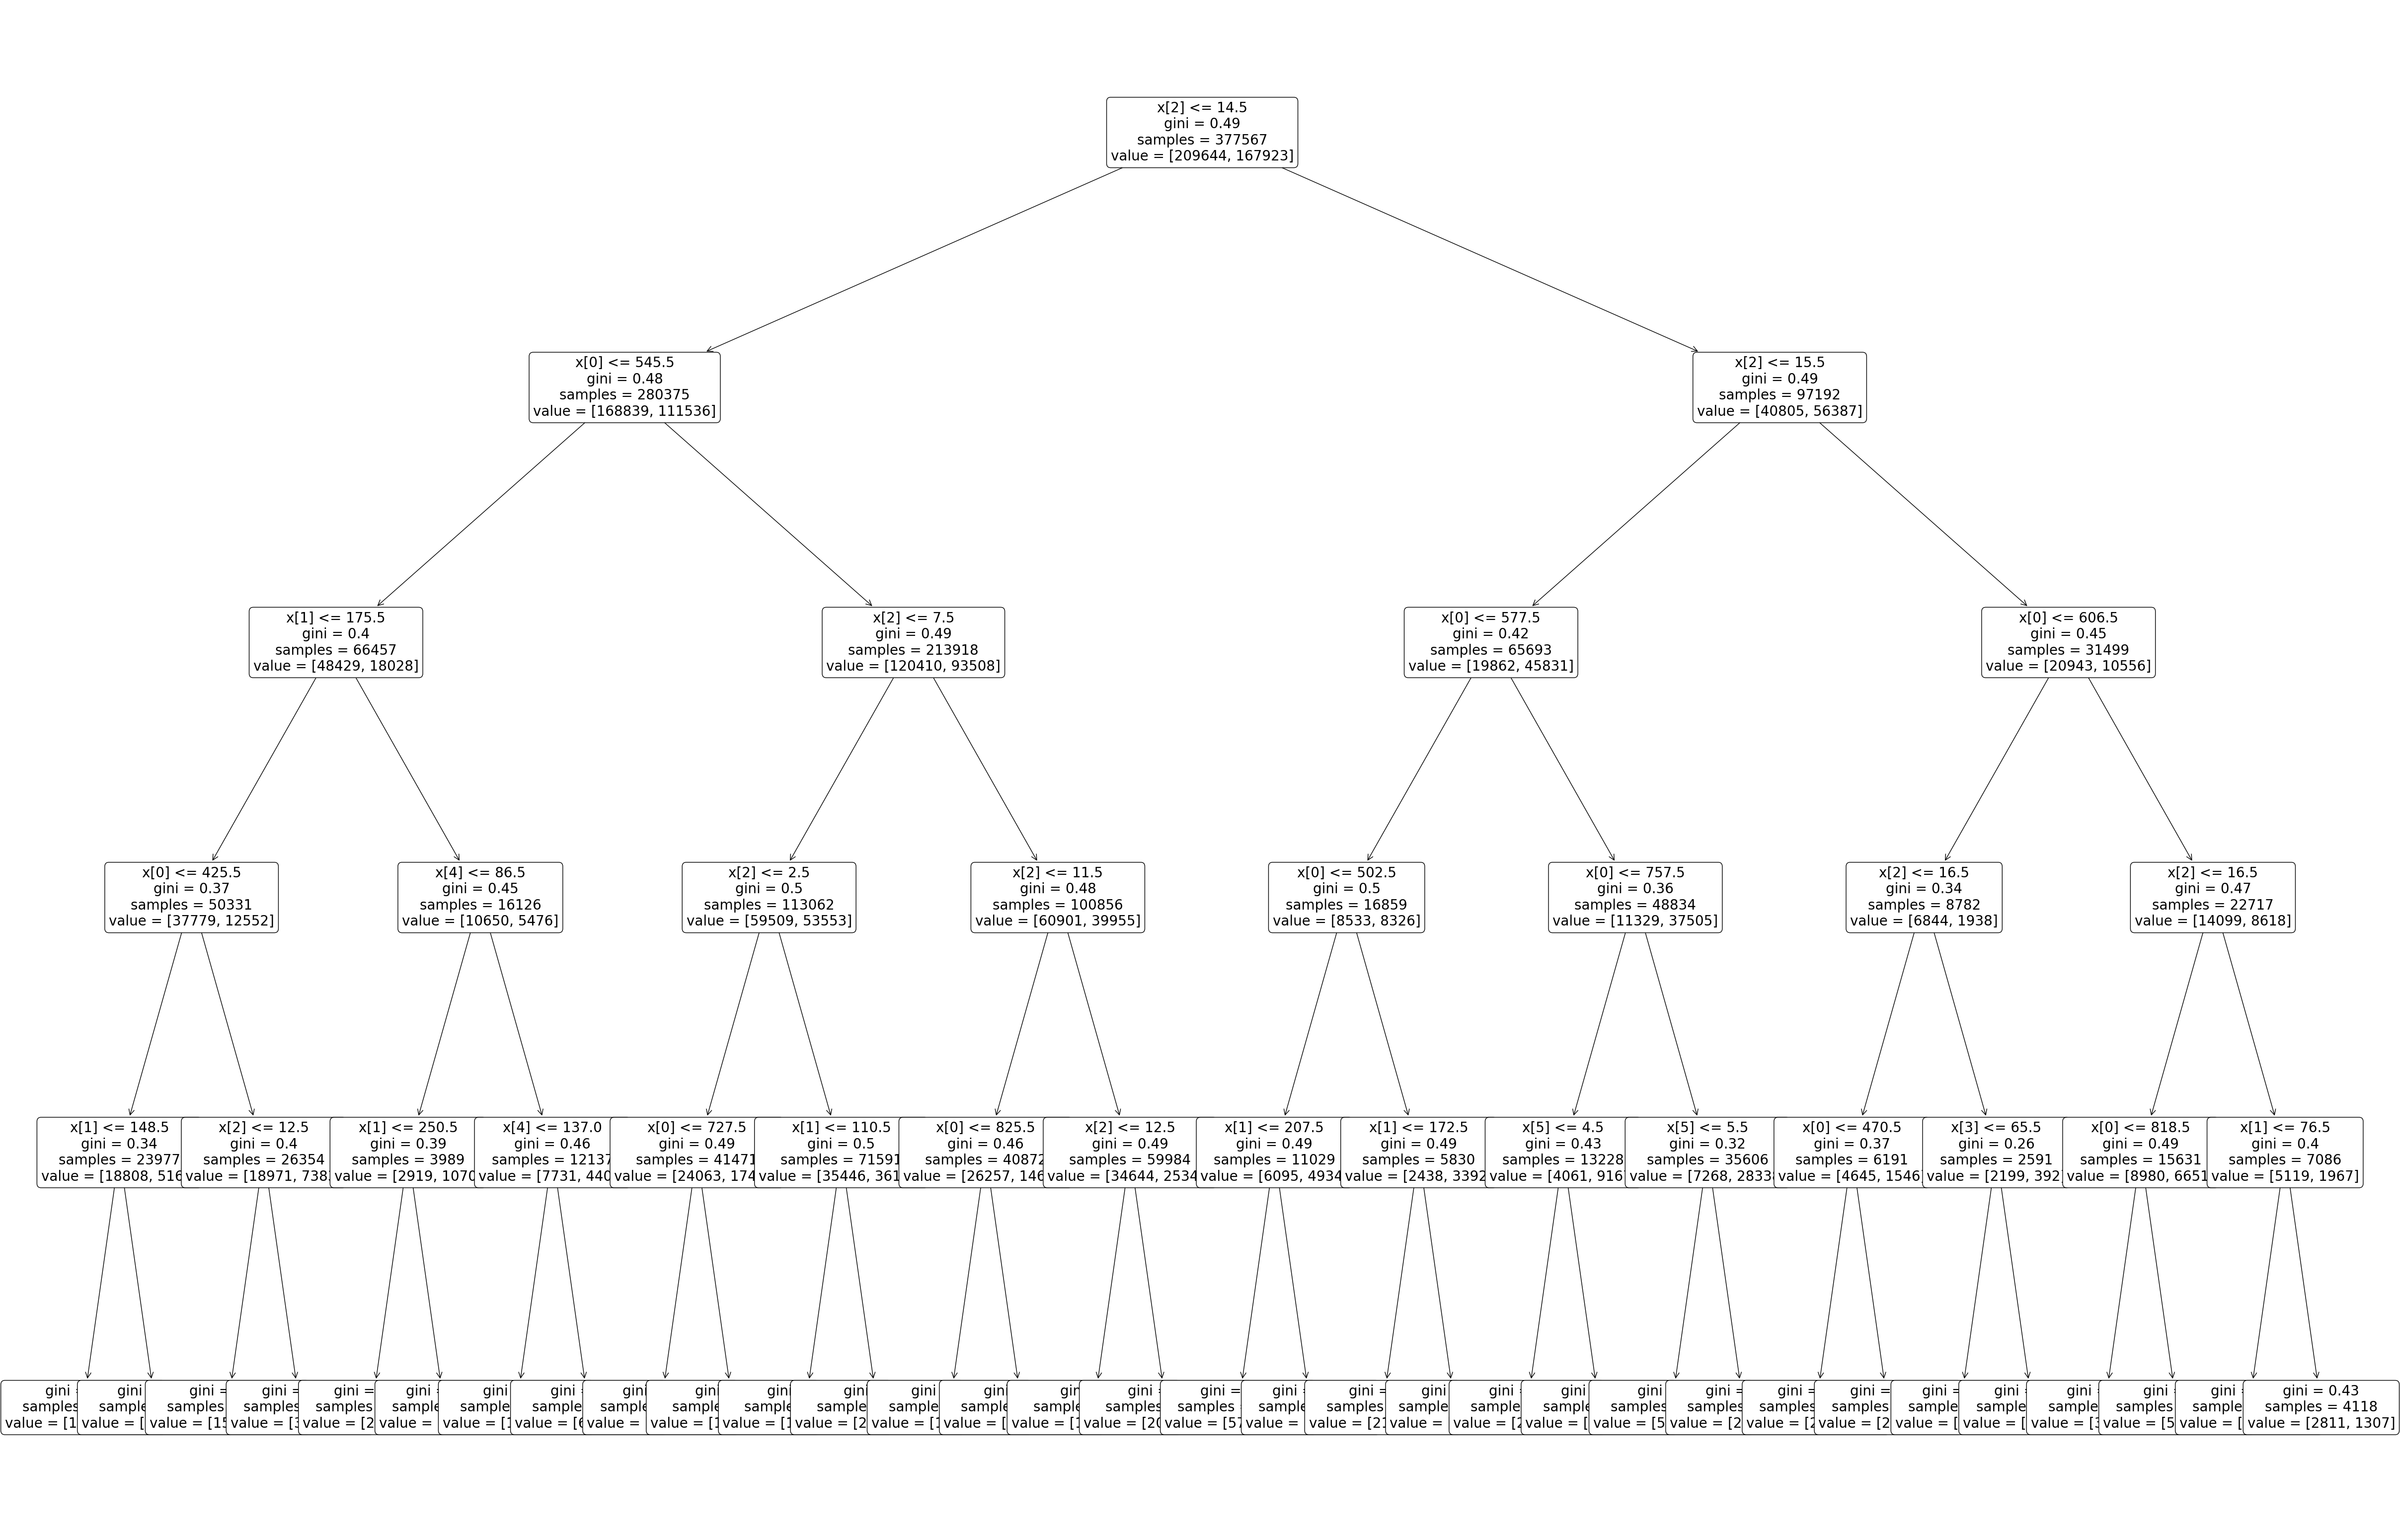

In [93]:
plt.figure(figsize=[60,40])
tree.plot_tree(dt_md,fontsize=20,rounded=True,impurity=True, precision=2)
plt.show()

## Support Vector Machine


## K-Nearest Neighbours

In [86]:
# Define parameter grid
param_knn = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

# Create KNN model
knn = KNeighborsClassifier()

# Create grid search object
knn_grid = GridSearchCV(knn, param_knn, cv=5, scoring='accuracy')

# Fit grid search on training data
start_time = time.time()
knn_grid.fit(X_train, Y_train)
train_time = time.time() - start_time

# Get best parameters and score
best_knn = knn_grid.best_estimator_
best_knn_params = knn_grid.best_params_
best_knn_score = knn_grid.best_score_

# Evaluate best KNN model on test data
start_time = time.time()
knn_train_pred = best_knn.predict(X_train)
knn_test_pred = best_knn.predict(X_test)
test_time = time.time() - start_time

print('Best Parameters:', best_knn_params)
print('Best Score:', round(best_knn_score*100, 2), '%')
print('Precision Score:', round(precision_score(Y_test, knn_test_pred)*100, 2), '%')
print('Recall Score:', round(recall_score(Y_test, knn_test_pred)*100, 2), '%')
print('Accuracy Score:', round(accuracy_score(Y_test, knn_test_pred)*100, 2), '%')
print('F-1 Score:', round(f1_score(Y_test, knn_test_pred)*100, 2), '%')
print('Training time:', round(train_time, 2), 'seconds')
print('Testing time:', round(test_time, 2), 'seconds')


Best Parameters: {'n_neighbors': 11}
Best Score: 64.35 %
Precision Score: 62.31 %
Recall Score: 53.86 %
Accuracy Score: 64.81 %
F-1 Score: 57.78 %
Training time: 84.84 seconds
Testing time: 10.5 seconds


### Confusion Matrix - Training

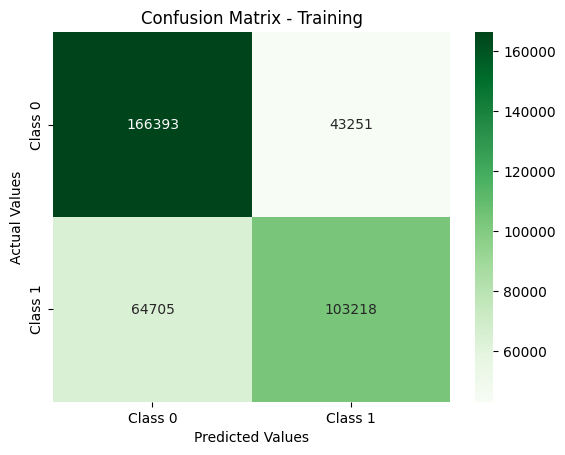

In [96]:
cm_train = confusion_matrix(Y_train, knn_train_pred)
class_labels = ['Class 0', 'Class 1']
sb.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### Confusion Matrix - Test

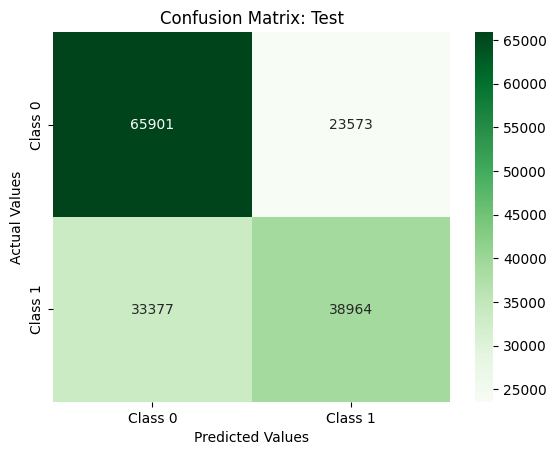

In [97]:
cm = confusion_matrix(Y_test, knn_test_pred)

class_labels = ['Class 0', 'Class 1']

sb.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix: Test')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()